In [1]:
# basic
import os
import sys
import time
import urllib.request

# data
import numpy as np

# viz
import cv2
from ipywidgets import Video
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

# dl
import torch

## GPU check

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Load model

In [3]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/anipi/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/anipi/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


## Move to GPU if possible

In [4]:
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

## Define the transforms

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/anipi/.cache/torch/hub/intel-isl_MiDaS_master


## Run model with test image

In [6]:
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7fc9736fbc90>)

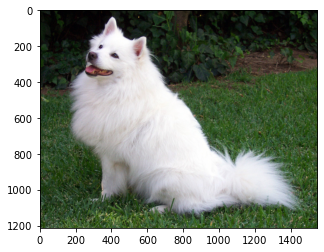

In [7]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
input_batch = transform(img).to(device)

In [8]:
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=(1213, 1546),
        mode="bicubic",
        align_corners=False,
    ).squeeze()

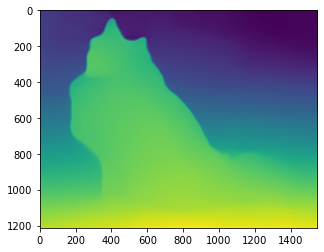

In [9]:
output = prediction.cpu().numpy()
plt.imshow(output)

## Run model real time on traffic video

In [10]:
def estimate_depth_video(input_video_path, output_video_path):
    
    # run the model every x frames 
    inference_frequency = 1
    
    fig, ax = plt.subplots()
    
    # grab basic info of the stream
    vcap = cv2.VideoCapture(input_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    
    # list of images to create an animation from
    prediction_images = []
    
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()
            
    frame_id = 0
    while ret:
        
        # run the prediction every inference_frequency frames
        if frame_id % inference_frequency == 0:
            
            # run the midas transforms
            input_batch = transform(frame).to(device)
            start_time = time.time()
            
            # run predictions
            with torch.no_grad():
                prediction = midas(input_batch)
                prediction = torch.nn.functional.interpolate(
                    prediction.unsqueeze(1),
                    size=frame.shape[:2],
                    mode="bicubic",
                    align_corners=False,
                ).squeeze()  

            # collect the output frame and populate for animation
            output_frame = prediction.cpu().numpy()
            im = ax.imshow(output_frame, animated=True)
            if frame_id == 0:
                ax.imshow(output_frame)
            prediction_images.append([im])
        
        
        # uncomment the below 4 lines if you want to see the actual video
        cv2.imshow('Frame', frame)
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
            
        frame_id+=1
        ret, frame = vcap.read()
    
    # create and save the animation
    output_animation = animation.ArtistAnimation(fig, prediction_images, interval=50, blit=True, repeat_delay=1000)
    output_animation.save(output_video_path)
    
    vcap.release()
    cv2.destroyAllWindows()

## Analyze the output

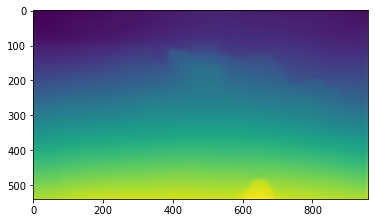

In [11]:
input_path = '../data/ua_detrac/ua_detrac.mp4'
output_path = 'video.mp4'
estimate_depth_video(input_path, output_path)

In [12]:
Video.from_file('video.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01b\x17mdat\x00\x…